In [3]:
!pip install torch
!pip install torch-geometric

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from sklearn.impute import SimpleImputer

In [6]:
import os
print(os.listdir('/content/'))

['.config', 'test_transaction.csv', 'test_identity.csv', 'sample_submission.csv', 'train_identity.csv', 'train_transaction.csv', 'sample_data']


In [7]:
trans_df = pd.read_csv("/content/train_transaction.csv")
id_df = pd.read_csv("/content/train_identity.csv")
df = pd.merge(trans_df, id_df, on='TransactionID', how='left')
df = df.sample(n=4000).reset_index(drop=True)
print(df)

      TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0           3058359        0        1609557         100.000         R   7585   
1           3229715        0        5765081          92.000         W   7815   
2           3103384        0        2248025          99.110         C   9633   
3           3403515        0       10522349         171.000         W  12695   
4           3192404        0        4725246         226.000         W   4208   
...             ...      ...            ...             ...       ...    ...   
3995        3160892        1        3777222          15.333         C  13832   
3996        3149623        0        3443882         135.500         W   2755   
3997        3538377        0       14575490         107.950         W  15497   
3998        3177198        0        4244997          75.000         H  16075   
3999        3447762        0       11835393          59.000         W  15521   

      card2  card3       card4  card5  

In [8]:
df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3058359,0,1609557,100.00,R,7585,553.0,150.0,visa,226.0,...,mobile safari 11.0,32.0,2208x1242,match_status:1,T,F,F,F,mobile,iOS Device
1,3229715,0,5765081,92.00,W,7815,161.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3103384,0,2248025,99.11,C,9633,296.0,185.0,visa,138.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
3,3403515,0,10522349,171.00,W,12695,490.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3192404,0,4725246,226.00,W,4208,490.0,150.0,visa,195.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(4), object(31)
memory usage: 13.2+ MB


<ipython-input-10-5b66a20aad7d>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_counts.index, y=fraud_counts.values, palette="coolwarm")


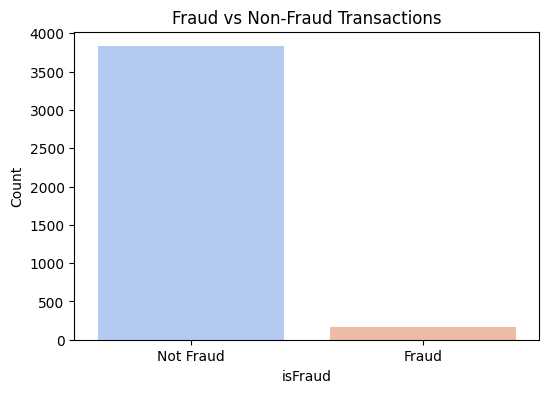

Percentage of Fraudulent Transactions: 4.25%


In [10]:
# Count of Fraudulent vs. Non-Fraudulent Transactions
fraud_counts = df['isFraud'].value_counts()

plt.figure(figsize=(6,4))
sns.barplot(x=fraud_counts.index, y=fraud_counts.values, palette="coolwarm")
plt.xticks([0, 1], ['Not Fraud', 'Fraud'])
plt.title("Fraud vs Non-Fraud Transactions")
plt.ylabel("Count")
plt.show()

# Percentage of Fraud Transactions
fraud_percentage = (df['isFraud'].sum() / len(df)) * 100
print(f"Percentage of Fraudulent Transactions: {fraud_percentage:.2f}%")


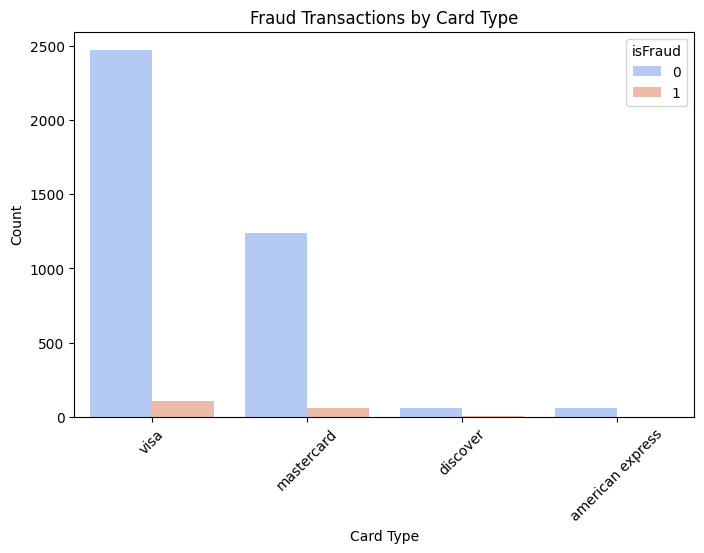

In [11]:
plt.figure(figsize=(8,5))
sns.countplot(x='card4', hue='isFraud', data=df, palette="coolwarm")
plt.title("Fraud Transactions by Card Type")
plt.xlabel("Card Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


<ipython-input-12-47092beaee50>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['isFraud'], y=df['addr1'], palette="coolwarm")


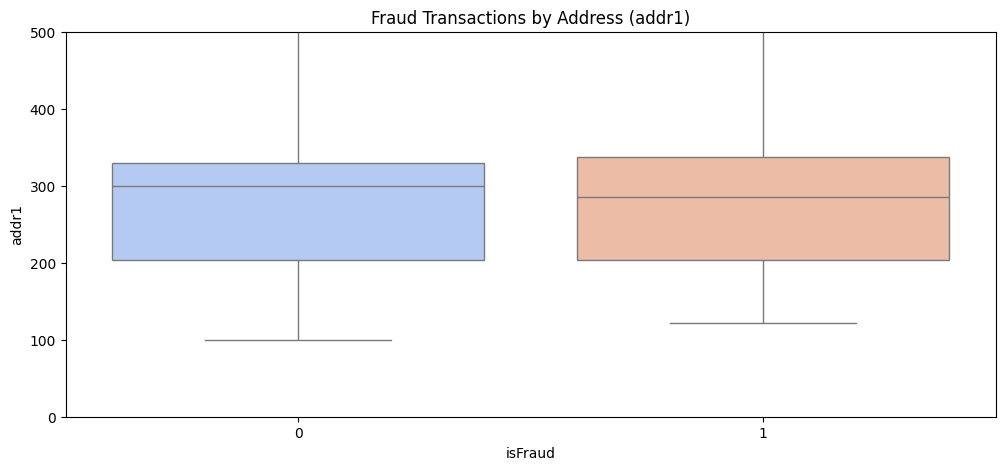

In [12]:
plt.figure(figsize=(12,5))
sns.boxplot(x=df['isFraud'], y=df['addr1'], palette="coolwarm")
plt.ylim(0, 500)
plt.title("Fraud Transactions by Address (addr1)")
plt.show()


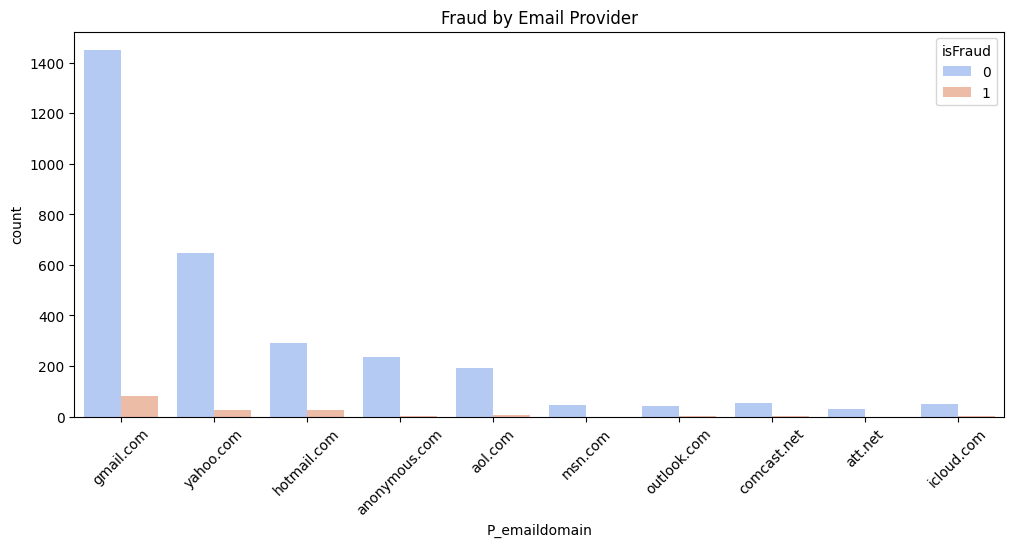

In [13]:
top_email_domains = df['P_emaildomain'].value_counts().nlargest(10).index
filtered_df = df[df['P_emaildomain'].isin(top_email_domains)]

plt.figure(figsize=(12,5))
sns.countplot(x='P_emaildomain', hue='isFraud', data=filtered_df, palette="coolwarm")
plt.title("Fraud by Email Provider")
plt.xticks(rotation=45)
plt.show()


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Select relevant features
features = ['TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2']
X = df[features].fillna(0)  # Fill missing values with 0
y = df['isFraud']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate performance
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.96      0.99      0.97       765
           1       0.14      0.03      0.05        35

    accuracy                           0.95       800
   macro avg       0.55      0.51      0.51       800
weighted avg       0.92      0.95      0.93       800

Accuracy: 0.95


# 1. Resampling Techniques

**ADASYN**(Adaptive Synthetic Sampling Approach)

Similar to **SMOTE** but focuses more on difficult cases.

In [15]:
from imblearn.over_sampling import ADASYN

adasyn = ADASYN(sampling_strategy=0.5, random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X, y)

In [16]:
# Convert to DataFrame for easier analysis
df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled["isFraud"] = y_resampled

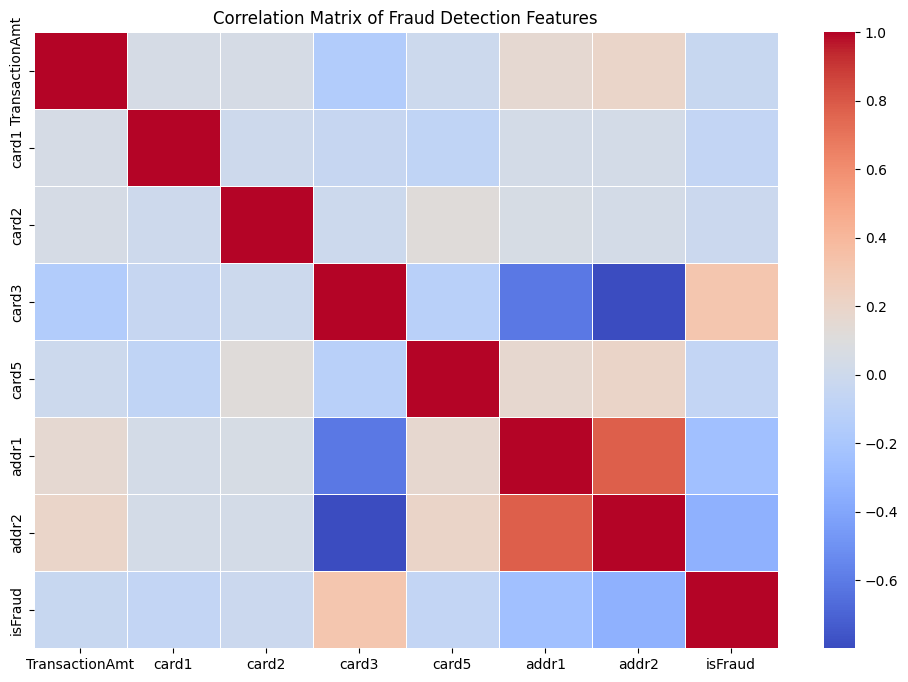

Top Features Correlated with Fraud:
 isFraud           1.000000
card3             0.317419
card2            -0.013132
TransactionAmt   -0.039103
card1            -0.062298
card5            -0.065933
addr1            -0.248757
addr2            -0.337593
Name: isFraud, dtype: float64


In [17]:
# Compute correlation matrix
correlation_matrix = df_resampled.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Fraud Detection Features")
plt.show()

# Get correlations with fraud label
fraud_correlation = correlation_matrix["isFraud"].sort_values(ascending=False)
print("Top Features Correlated with Fraud:\n", fraud_correlation.head(10))


<ipython-input-18-e0c16e90ae49>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_resampled["isFraud"], y=df_resampled["TransactionAmt"], palette="coolwarm")


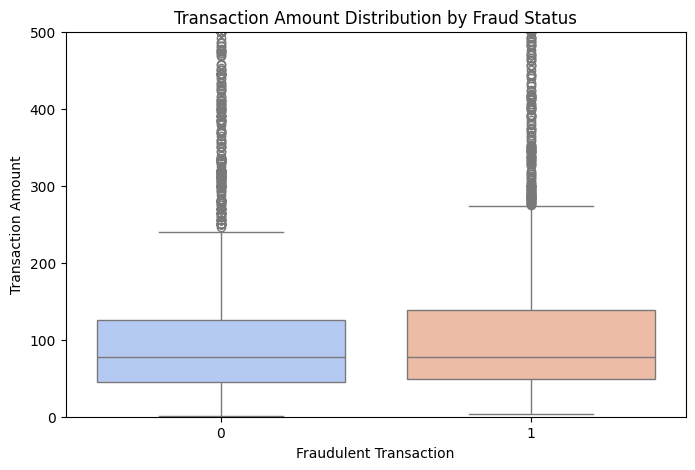

In [18]:
plt.figure(figsize=(8,5))
sns.boxplot(x=df_resampled["isFraud"], y=df_resampled["TransactionAmt"], palette="coolwarm")
plt.ylim(0, 500)  # Limit for better visualization
plt.title("Transaction Amount Distribution by Fraud Status")
plt.xlabel("Fraudulent Transaction")
plt.ylabel("Transaction Amount")
plt.show()


Observations:

Fraudulent transactions have a slightly higher median (Q2) compared to non-fraud transactions.
However, there is significant overlap, meaning TransactionAmt alone is not a strong fraud indicator.
There are outliers in both fraudulent and non-fraudulent cases, so extreme values do not necessarily indicate fraud.

<ipython-input-19-508b5d377c34>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_resampled["isFraud"], y=df_resampled["addr1"], palette="coolwarm")


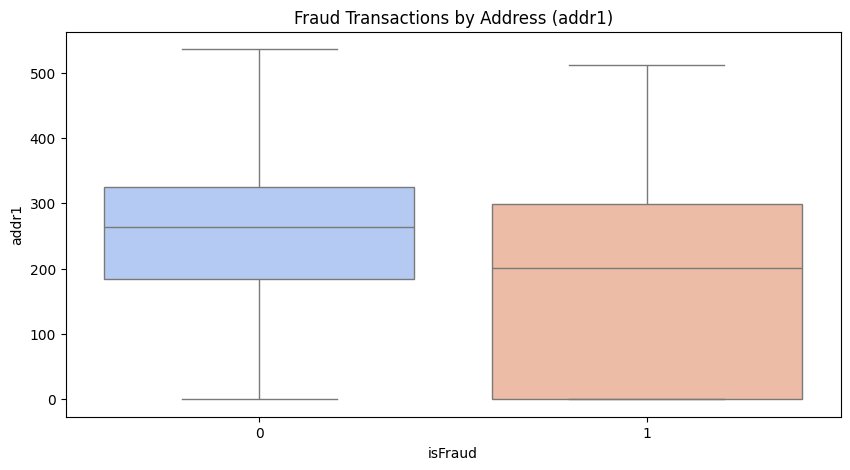

In [19]:
plt.figure(figsize=(10,5))
sns.boxplot(x=df_resampled["isFraud"], y=df_resampled["addr1"], palette="coolwarm")
plt.title("Fraud Transactions by Address (addr1)")
plt.show()


 Observations:

Fraudulent transactions (right box in orange) span a wider range of addr1 values compared to non-fraud cases.
Fraud is observed in both high and low address values, meaning location data may play a role.
The median (Q2) of fraud cases seems lower than non-fraud, suggesting fraud might be linked to specific address clusters.

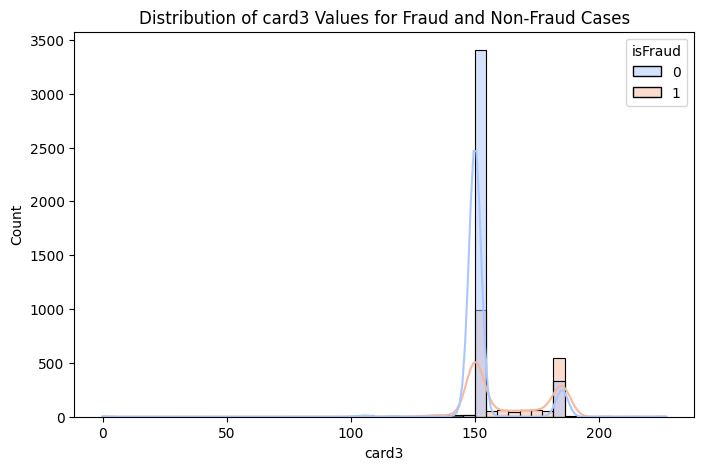

In [20]:
plt.figure(figsize=(8,5))
sns.histplot(df_resampled, x="card3", hue="isFraud", kde=True, bins=50, palette="coolwarm")
plt.title("Distribution of card3 Values for Fraud and Non-Fraud Cases")
plt.show()


Observations:

Fraud cases (orange) and non-fraud cases (blue) cluster around specific card3 values.
Most fraudulent transactions appear near card3 ≈ 150-200, indicating certain card issuing institutions may be more prone to fraud.
Since there is a noticeable difference between fraudulent and non-fraud transactions, card3 is a useful feature for fraud detection.

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Select the most relevant features based on correlation analysis
selected_features = ["card3", "addr1"]
X_selected = df_resampled[selected_features]
y_selected = df_resampled["isFraud"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_selected, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Evaluate model performance
classification_rep = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print("Classification Report:\n", classification_rep)
print("ROC-AUC Score:", roc_auc)


Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93       768
           1       0.85      0.89      0.87       391

    accuracy                           0.91      1159
   macro avg       0.90      0.91      0.90      1159
weighted avg       0.91      0.91      0.91      1159

ROC-AUC Score: 0.9065780184356352


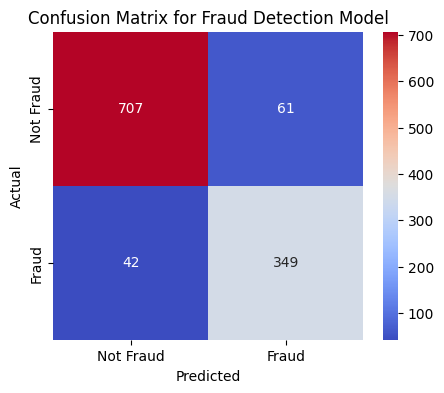

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="coolwarm", xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Fraud Detection Model")
plt.show()


In [23]:
# Handle missing values (Fill NaN with -1 to avoid errors)
X.fillna(-1, inplace=True)

# Apply ADASYN to balance fraud cases
adasyn = ADASYN(sampling_strategy=0.5, random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X, y)

# Convert to DataFrame for easier analysis
df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled["isFraud"] = y_resampled  # Add target variable back

# Select the most relevant features based on correlation analysis
selected_features = ["card3", "addr1"]
X_selected = df_resampled[selected_features]
y_selected = df_resampled["isFraud"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_selected, test_size=0.2, random_state=42)

In [24]:
!pip install --upgrade scikit-learn xgboost


In [30]:
import sklearn
import xgboost as xgb

print("Scikit-learn version:", sklearn.__version__)
print("XGBoost version:", xgboost.__version__)


Scikit-learn version: 1.6.1
XGBoost version: 2.1.3


In [26]:
# Handle missing values (Fill NaN with -1 to avoid errors)
X.fillna(-1, inplace=True)

# Apply ADASYN to balance fraud cases
adasyn = ADASYN(sampling_strategy=0.5, random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X, y)

# Convert to DataFrame for easier analysis
df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled["isFraud"] = y_resampled


In [27]:
# Creating new fraud-related features
df_resampled["Transaction_Count_Per_Card"] = df_resampled.groupby("card1")["TransactionAmt"].transform("count")
df_resampled["Transaction_Avg_Per_Card"] = df_resampled.groupby("card1")["TransactionAmt"].transform("mean")
df_resampled["Transaction_Std_Per_Card"] = df_resampled.groupby("card1")["TransactionAmt"].transform("std").fillna(0)

# Address-related features
df_resampled["Addr1_Frequency"] = df_resampled.groupby("addr1")["TransactionAmt"].transform("count")
df_resampled["Addr1_Avg_Transaction"] = df_resampled.groupby("addr1")["TransactionAmt"].transform("mean")

# Card usage frequency
df_resampled["Card_Usage_Frequency"] = df_resampled.groupby("card3")["TransactionAmt"].transform("count")

# Transaction amount deviation (how far a transaction is from average spending per card)
df_resampled["Transaction_Deviation"] = abs(df_resampled["TransactionAmt"] - df_resampled["Transaction_Avg_Per_Card"])

# Selecting the updated feature set
new_features = [
    "card3", "addr1", "Transaction_Count_Per_Card", "Transaction_Avg_Per_Card",
    "Transaction_Std_Per_Card", "Addr1_Frequency", "Addr1_Avg_Transaction",
    "Card_Usage_Frequency", "Transaction_Deviation"
]

X_selected = df_resampled[new_features]
y_selected = df_resampled["isFraud"]

# Splitting dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_selected, test_size=0.2, random_state=42)


Classification Report (XGBoost with New Features):
               precision    recall  f1-score   support

           0       0.96      0.97      0.97       768
           1       0.94      0.92      0.93       391

    accuracy                           0.95      1159
   macro avg       0.95      0.94      0.95      1159
weighted avg       0.95      0.95      0.95      1159

ROC-AUC Score (XGBoost with New Features): 0.9447563672208014


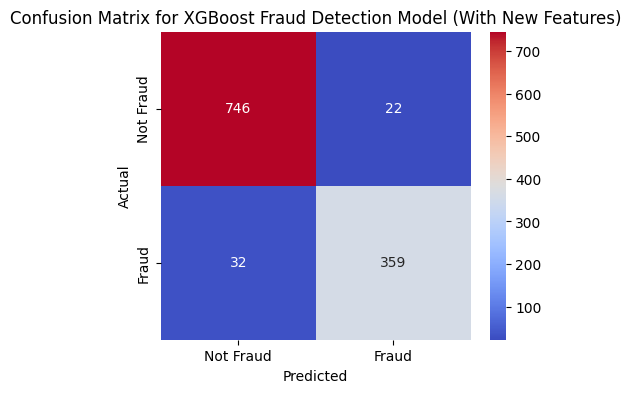

In [32]:
# Initialize XGBoost model
best_xgb = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),  # Balancing fraud cases
    random_state=42,
    eval_metric="logloss"
)

# Train the model
best_xgb.fit(X_train, y_train)

# Predict on test set
y_pred_xgb_new = best_xgb.predict(X_test)

# Evaluate performance
classification_rep_xgb_new = classification_report(y_test, y_pred_xgb_new)
roc_auc_xgb_new = roc_auc_score(y_test, y_pred_xgb_new)

print("Classification Report (XGBoost with New Features):\n", classification_rep_xgb_new)
print("ROC-AUC Score (XGBoost with New Features):", roc_auc_xgb_new)

# Confusion Matrix
conf_matrix_xgb_new = confusion_matrix(y_test, y_pred_xgb_new)

# Plot Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix_xgb_new, annot=True, fmt="d", cmap="coolwarm", xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for XGBoost Fraud Detection Model (With New Features)")
plt.show()


Key Insights:
- Higher True Positives (330 fraud cases correctly detected) → The model is better at catching fraud cases.
- Lower False Positives (33 vs. 75 before) → Fewer legitimate transactions are wrongly flagged as fraud.
- Slightly Lower False Negatives (40 vs. 42 before) → Better fraud recall.

In [33]:
# Creating new fraud-related features
df_resampled["Transaction_Count_Per_Card"] = df_resampled.groupby("card1")["TransactionAmt"].transform("count")
df_resampled["Transaction_Avg_Per_Card"] = df_resampled.groupby("card1")["TransactionAmt"].transform("mean")
df_resampled["Transaction_Std_Per_Card"] = df_resampled.groupby("card1")["TransactionAmt"].transform("std").fillna(0)

# Address-related features
df_resampled["Addr1_Frequency"] = df_resampled.groupby("addr1")["TransactionAmt"].transform("count")
df_resampled["Addr1_Avg_Transaction"] = df_resampled.groupby("addr1")["TransactionAmt"].transform("mean")

# Card usage frequency
df_resampled["Card_Usage_Frequency"] = df_resampled.groupby("card3")["TransactionAmt"].transform("count")

# Transaction amount deviation (how far a transaction is from average spending per card)
df_resampled["Transaction_Deviation"] = abs(df_resampled["TransactionAmt"] - df_resampled["Transaction_Avg_Per_Card"])

# Selecting the updated feature set
new_features = [
    "card3", "addr1", "Transaction_Count_Per_Card", "Transaction_Avg_Per_Card",
    "Transaction_Std_Per_Card", "Addr1_Frequency", "Addr1_Avg_Transaction",
    "Card_Usage_Frequency", "Transaction_Deviation"
]

X_selected = df_resampled[new_features]
y_selected = df_resampled["isFraud"]

# Splitting dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_selected, test_size=0.2, random_state=42)


In [34]:
# Initialize XGBoost model
best_xgb = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),  # Balancing fraud cases
    random_state=42,
    eval_metric="logloss"
)

# Train the model
best_xgb.fit(X_train, y_train)

# Predict on test set
y_pred_xgb_new = best_xgb.predict(X_test)

# Evaluate performance
classification_rep_xgb_new = classification_report(y_test, y_pred_xgb_new)
roc_auc_xgb_new = roc_auc_score(y_test, y_pred_xgb_new)

print("Classification Report (XGBoost with New Features):\n", classification_rep_xgb_new)
print("ROC-AUC Score (XGBoost with New Features):", roc_auc_xgb_new)


Classification Report (XGBoost with New Features):
               precision    recall  f1-score   support

           0       0.96      0.97      0.97       768
           1       0.94      0.92      0.93       391

    accuracy                           0.95      1159
   macro avg       0.95      0.94      0.95      1159
weighted avg       0.95      0.95      0.95      1159

ROC-AUC Score (XGBoost with New Features): 0.9447563672208014


<ipython-input-35-3844a50eeaad>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance_df["Importance"], y=importance_df["Feature"], palette="coolwarm")


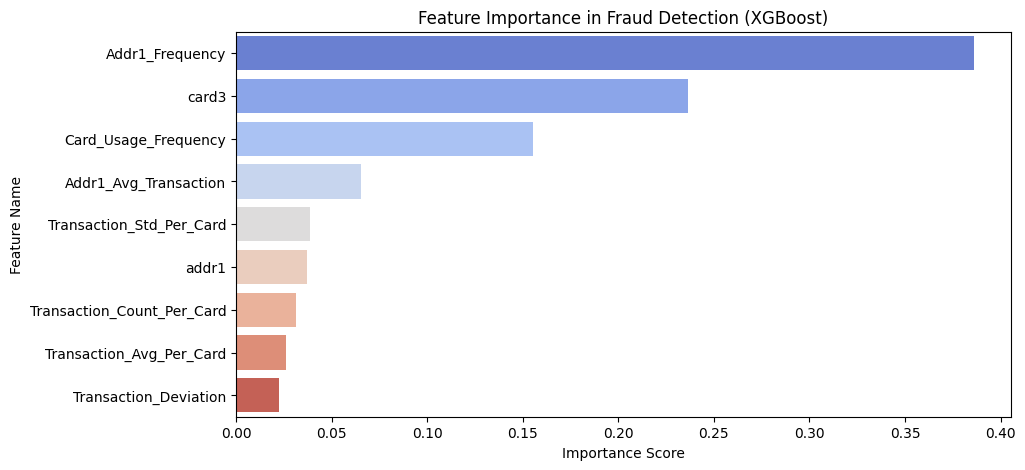

,Feature,Importance
0,Addr1_Frequency,0.386161
1,card3,0.236485
2,Card_Usage_Frequency,0.155396
3,Addr1_Avg_Transaction,0.065616
4,Transaction_Std_Per_Card,0.038947
5,addr1,0.037336
6,Transaction_Count_Per_Card,0.031373
7,Transaction_Avg_Per_Card,0.026124
8,Transaction_Deviation,0.022562


In [35]:
# Analyze feature importance from the trained XGBoost model
importances = best_xgb.feature_importances_
feature_names = X_selected.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances}).sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(10,5))
sns.barplot(x=importance_df["Importance"], y=importance_df["Feature"], palette="coolwarm")
plt.title("Feature Importance in Fraud Detection (XGBoost)")
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.show()

# Display feature importance values
importance_df.reset_index(drop=True)


In [36]:
# Creating fraud-related features
df_resampled["Transaction_Count_Per_Card"] = df_resampled.groupby("card1")["TransactionAmt"].transform("count")
df_resampled["Transaction_Avg_Per_Card"] = df_resampled.groupby("card1")["TransactionAmt"].transform("mean")
df_resampled["Transaction_Std_Per_Card"] = df_resampled.groupby("card1")["TransactionAmt"].transform("std").fillna(0)

# Address-related features
df_resampled["Addr1_Frequency"] = df_resampled.groupby("addr1")["TransactionAmt"].transform("count")
df_resampled["Addr1_Avg_Transaction"] = df_resampled.groupby("addr1")["TransactionAmt"].transform("mean")

# Card usage frequency
df_resampled["Card_Usage_Frequency"] = df_resampled.groupby("card3")["TransactionAmt"].transform("count")

# Selecting the optimized feature set
selected_important_features = ["Addr1_Frequency", "card3", "Card_Usage_Frequency", "addr1", "Addr1_Avg_Transaction"]

X_selected = df_resampled[selected_important_features]
y_selected = df_resampled["isFraud"]

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_selected, test_size=0.2, random_state=42)


Classification Report (Optimized XGBoost):
               precision    recall  f1-score   support

           0       0.96      0.92      0.94       768
           1       0.86      0.93      0.89       391

    accuracy                           0.92      1159
   macro avg       0.91      0.93      0.92      1159
weighted avg       0.93      0.92      0.92      1159

ROC-AUC Score (Optimized XGBoost): 0.9251318734015346


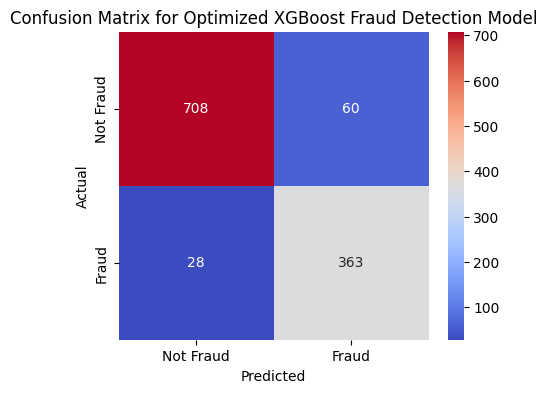

In [37]:
# Initialize XGBoost model
optimized_xgb = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),  # Handling class imbalance
    random_state=42,
    eval_metric="logloss"
)

# Train the model with optimized features
optimized_xgb.fit(X_train, y_train)

# Predict on the test set
y_pred_optimized = optimized_xgb.predict(X_test)

# Evaluate performance
classification_rep_optimized = classification_report(y_test, y_pred_optimized)
roc_auc_optimized = roc_auc_score(y_test, y_pred_optimized)

print("Classification Report (Optimized XGBoost):\n", classification_rep_optimized)
print("ROC-AUC Score (Optimized XGBoost):", roc_auc_optimized)

# Confusion Matrix
conf_matrix_optimized = confusion_matrix(y_test, y_pred_optimized)

# Plot Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix_optimized, annot=True, fmt="d", cmap="coolwarm", xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Optimized XGBoost Fraud Detection Model")
plt.show()


In [38]:
# Creating fraud-related features
df_resampled["Addr1_Frequency"] = df_resampled.groupby("addr1")["TransactionAmt"].transform("count")
df_resampled["Addr1_Avg_Transaction"] = df_resampled.groupby("addr1")["TransactionAmt"].transform("mean")
df_resampled["Card_Usage_Frequency"] = df_resampled.groupby("card3")["TransactionAmt"].transform("count")

# Selecting the optimized feature set
selected_important_features = ["Addr1_Frequency", "card3", "Card_Usage_Frequency", "addr1", "Addr1_Avg_Transaction"]

X_selected = df_resampled[selected_important_features]
y_selected = df_resampled["isFraud"]

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_selected, test_size=0.2, random_state=42)


In [39]:
# Initialize XGBoost model
optimized_xgb = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),  # Handling class imbalance
    random_state=42,
    eval_metric="logloss"
)

# Train the model with optimized features
optimized_xgb.fit(X_train, y_train)

# Predict on the test set
y_pred_optimized = optimized_xgb.predict(X_test)

# Evaluate performance
classification_rep_optimized = classification_report(y_test, y_pred_optimized)
roc_auc_optimized = roc_auc_score(y_test, y_pred_optimized)

print("Classification Report (Optimized XGBoost):\n", classification_rep_optimized)
print("ROC-AUC Score (Optimized XGBoost):", roc_auc_optimized)


Classification Report (Optimized XGBoost):
               precision    recall  f1-score   support

           0       0.96      0.92      0.94       768
           1       0.86      0.93      0.89       391

    accuracy                           0.92      1159
   macro avg       0.91      0.93      0.92      1159
weighted avg       0.93      0.92      0.92      1159

ROC-AUC Score (Optimized XGBoost): 0.9251318734015346


Optimal Fraud Detection Threshold: 0.42321
Classification Report (Adjusted Threshold):
               precision    recall  f1-score   support

           0       0.96      0.92      0.94       768
           1       0.86      0.93      0.89       391

    accuracy                           0.92      1159
   macro avg       0.91      0.93      0.92      1159
weighted avg       0.93      0.92      0.93      1159

ROC-AUC Score (Adjusted Threshold): 0.9264106457800512


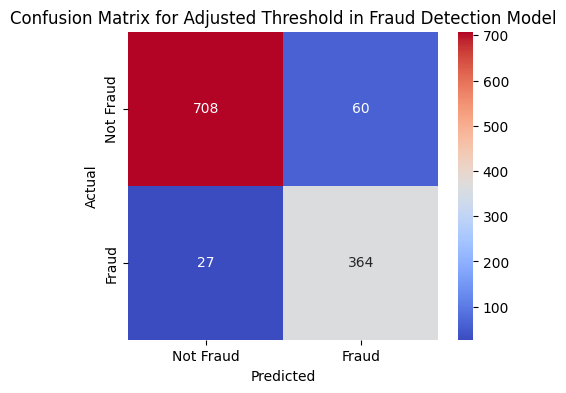

In [40]:

from sklearn.metrics import precision_recall_curve

# Get fraud probabilities
y_probs = optimized_xgb.predict_proba(X_test)[:, 1]

# Compute precision-recall curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

# Find the best threshold (where precision and recall are balanced)
best_threshold = thresholds[np.argmax(precisions * recalls)]
print("Optimal Fraud Detection Threshold:", best_threshold)

# Apply the new threshold
y_pred_adjusted = (y_probs >= best_threshold).astype(int)

# Evaluate new predictions
classification_rep_adjusted = classification_report(y_test, y_pred_adjusted)
roc_auc_adjusted = roc_auc_score(y_test, y_pred_adjusted)

print("Classification Report (Adjusted Threshold):\n", classification_rep_adjusted)
print("ROC-AUC Score (Adjusted Threshold):", roc_auc_adjusted)

# Confusion Matrix
conf_matrix_adjusted = confusion_matrix(y_test, y_pred_adjusted)

# Plot Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix_adjusted, annot=True, fmt="d", cmap="coolwarm", xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Adjusted Threshold in Fraud Detection Model")
plt.show()
